In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# work with the fastai V1 library which sits on top of Pytorch 1.0
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [3]:
df = pd.read_csv('/home/jramsay/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [9]:
np.random.seed(42)
src = (ImageItemList.from_csv('/home/jramsay/', 'train_labels.csv', folder='train_img', suffix='.tif')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' ')
       .add_test_folder(test_folder='test_img'))

In [10]:
data = (src.transform(tfms, size=96)
        .databunch().normalize(imagenet_stats))

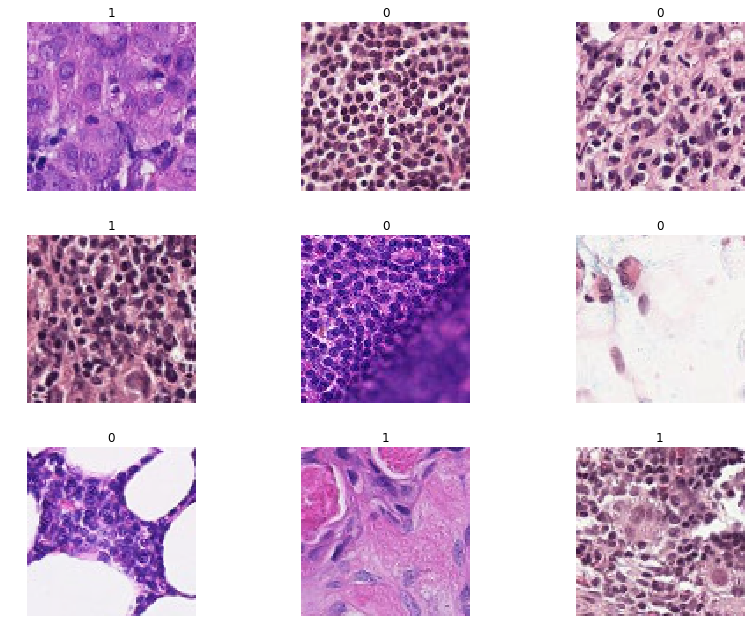

In [11]:
data.show_batch(rows=3, figsize=(12,9))

In [16]:
arch = models.resnet50
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch)#, metrics=[acc_02, f_score]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


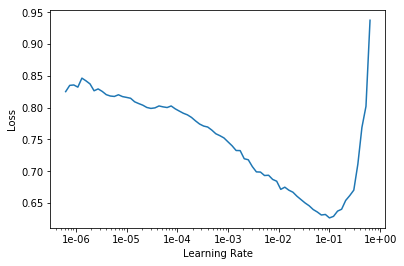

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
lr=1e-2

In [18]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss
1,0.203589,0.194012
2,0.170301,0.139736


In [19]:
learn.save('stage-1-96-rn50')

In [27]:
preds, y_test = learn.get_preds(ds_type=DatasetType.Test)

In [28]:
sub=pd.read_csv('/home/jramsay/sample_submission.csv').set_index('id')
sub.head()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [29]:
clean_fname=np.vectorize(lambda fname: str(fname).split('/')[-1].split('.')[0])
fname_cleaned=clean_fname(data.test_ds.items)
fname_cleaned=fname_cleaned.astype(str)

In [33]:
sub.loc[fname_cleaned,'label']=to_np(preds[:,1])
sub.to_csv('Cancer_sub_v1.csv')

In [48]:
learn.unfreeze()

In [49]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.159269,0.138189,0.932224,0.963986
2,0.146361,0.127020,0.941098,0.965898
3,0.123038,0.109409,0.948733,0.971988
4,0.104082,0.087960,0.960550,0.976912
5,0.096745,0.084401,0.961811,0.978074


In [50]:
learn.save('stage-2-96-rn50')

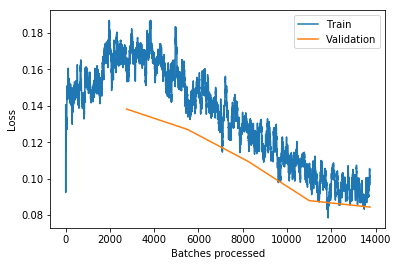

In [51]:
learn.recorder.plot_losses()

,label
id,
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [138]:
preds = learn.get_preds(ds_type=DatasetType.Test)

TypeError: get_preds() got an unexpected keyword argument 'shuffle'